## Introducing Heavy Tails

(5000, 3)


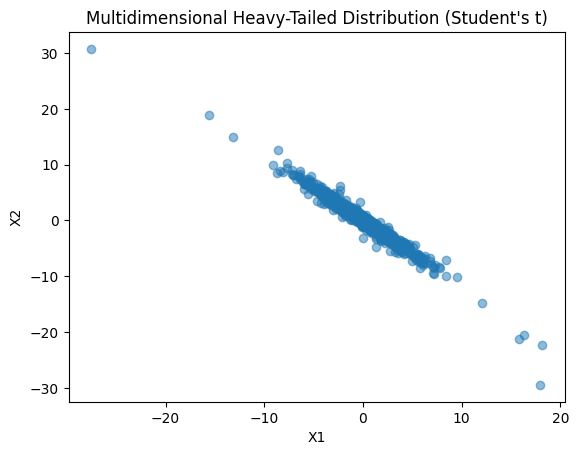

In [70]:
import numpy as np

def generate_heavy_tailed_distribution(n_samples=1000, df=3, dim=3, seed=219):
    np.random.seed(seed)

    # Mean vector (center of distribution)
    mean = np.zeros(dim)

    # Covariance matrix (random positive-definite matrix)
    A = np.random.randn(dim, dim)
    cov_matrix = np.dot(A, A.T)  # Ensures it's positive semi-definite

    # Generate multivariate normal samples
    normal_samples = np.random.multivariate_normal(mean, cov_matrix, size=n_samples)

    # Generate chi-squared distributed samples
    chi_samples = np.random.chisquare(df, size=(n_samples, 1))

    # Compute heavy-tailed Student’s t-distributed samples
    t_samples = normal_samples / np.sqrt(chi_samples / df)

    return t_samples

# Generate samples
samples = generate_heavy_tailed_distribution(n_samples=5000)

# Display shape
print(samples.shape)

# Optionally, visualize one 2D projection
import matplotlib.pyplot as plt

plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Multidimensional Heavy-Tailed Distribution (Student's t)")
plt.show()


For now, basic code is without heavy-tailed noise. Instead I use a normal noise.

## Loading data

In [3]:
import requests
from sklearn.datasets import load_svmlight_file

# URL of the file to download
url = 'https://hse24.fmin.xyz/files/mushrooms.txt'

# Download the file and save it locally
response = requests.get(url)
dataset = 'mushrooms.txt'

# Ensure the request was successful
if response.status_code == 200:
    with open(dataset, 'wb') as f:
        f.write(response.content)

    # Load the dataset from the downloaded file
    data = load_svmlight_file(dataset)
    A, b = data[0].toarray(), data[1]
    n, d = A.shape
    b = (b - 3/2) * 2 # to +-1
    print("Data loaded successfully.")
    print(f"Number of samples: {n}, Number of features: {d}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

Data loaded successfully.
Number of samples: 8124, Number of features: 112


In [74]:
from sklearn.model_selection import train_test_split
# Split the data into training and test sets
# Number of workers
num_workers = 20

A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=214)

# Initialize empty lists for workers
X_splits, y_splits = [], []

X_remaining, y_remaining = A_train, b_train
for _ in range(num_workers - 1):  # Last worker gets remaining data
    X_part, X_remaining, y_part, y_remaining = train_test_split(
        X_remaining, y_remaining, train_size=1/(num_workers - len(X_splits)), stratify=y_remaining
    )
    X_splits.append(X_part)
    y_splits.append(y_part)

X_splits.append(X_remaining)  # Last split
y_splits.append(y_remaining)

# Workers' data
workers_data = list(zip(X_splits, y_splits))

workers_data[0][0].shape

(324, 112)

## Experiment

In [2]:
import pickle

def pickle_data(data, data_name, version_name):
    with open(f"../data/{version_name}/{data_name}_{version_name}.pkl", "wb") as f:
        pickle.dump(data, f)

In [41]:
from jax import jit
import jax.numpy as jnp
@jit
def logistic_loss(w, X, y, mu=1):
    m, n = X.shape
    return jnp.sum(jnp.logaddexp(0, -y * (X @ w))) / m + mu / 2 * jnp.sum(w**2)

In [46]:
def compute_objective_regression(mat_A, vec_b, point_w, reg_const):
    log_terms = np.log(1 + np.exp(-vec_b * (mat_A @ point_w)))
    reg_term = (reg_const/2) * np.linalg.norm(point_w)**2
    return np.mean(log_terms) + reg_term

def compute_gradient_regression(mat_A, vec_b, point_w, reg_const):
    m = mat_A.shape[0]
    sigmoid_vec = 1 / (1 + np.exp(vec_b * (mat_A @ point_w)))
    return (1/m) * mat_A.T @ (-vec_b * sigmoid_vec) + reg_const * point_w


In [10]:
import cvxpy as cp
def compute_optimal_regression(X, y, mu):
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum(cp.logistic(cp.multiply(-y, X @ w))) / len(y) + mu / 2 * cp.norm(w, 2)**2)
    problem = cp.Problem(objective)
    problem.solve()
    return w.value, problem.value

In [8]:
def sign_grad(grad):
    return np.sign(grad)

In [85]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import time


def regression_gradient_descent(w_init, work_data, alpha, max_iter, lambda_reg, alg='gd', noise=None, send_time=1e-4):
    times = [0]
    iter_start = time.time()

    trajectory = [w_init.copy()]
    w = w_init.copy()
    send_timer = 0
    for _ in range(max_iter):
        sum_grads = 0
        for mat_A, vec_b in work_data:
            pure_grad = compute_gradient_regression(mat_A, vec_b, w, lambda_reg)
            noise_grad = np.random.normal(0, 1/2, w.shape) if noise == 'normal' else 0
            grad = pure_grad + noise_grad

            if alg=='gd':
                sum_grads += grad
                send_timer += send_time * 8 # because floats instead of bools
            if alg =='sign_sgd':
                sum_grads += np.sign(grad)
                send_timer += send_time

        if alg == 'gd':
            w = w - alpha * sum_grads / len(work_data)
        if alg == 'sign_sgd':
            w = w - alpha * sign_grad(sum_grads)


        trajectory.append(w.copy())        
        iter_time = time.time()
        times.append(iter_time - iter_start + send_timer)

    return trajectory, times



In [71]:
@jit
def compute_accuracy(w, X, y):
    # Compute predicted probabilities using the logistic (sigmoid) function
    preds_probs = jax.nn.sigmoid(X @ w)
    # Convert probabilities to class predictions: -1 if p < 0.5, else 1
    preds = jnp.where(preds_probs < 0.5, -1, 1)
    # Calculate accuracy as the average of correct predictions
    accuracy = jnp.mean(preds == y)
    return accuracy

In [29]:
import jax.numpy as jnp
def compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu):
    f = lambda w: logistic_loss(w, X_train, y_train, mu)
    metrics = {
        "f_gap": [jnp.abs(f(x) - f_star) for x in trajectory],
        "x_gap": [jnp.linalg.norm(x - x_star) for x in trajectory],
        "time": times,
        "train_acc": [compute_accuracy(x, X_train, y_train) for x in trajectory],
        "test_acc": [compute_accuracy(x, X_test, y_test) for x in trajectory],
    }
    return metrics

In [80]:
def run_experiments(params):
    mu = params["mu"]
    methods = params["methods"]
    sending_time = params["sending_time"]

    results = {}

    X_train = A_train
    y_train = b_train
    X_test = A_test
    y_test = b_test
    n_features = X_train.shape[1]  # Number of features
    params["n_features"] = n_features

    x_0 = jax.random.normal(jax.random.PRNGKey(0), (n_features, ))
    # x_0 = np.ones(n_features)
    x_star, f_star = compute_optimal_regression(X_train, y_train, mu)

    for method in methods:
        if method["method"] == "SGD":
            learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            noise = method["noise_type"]
            trajectory, times = regression_gradient_descent(x_0, workers_data, learning_rate, iterations, mu, alg='gd', noise=noise, send_time=sending_time)
            label = f'{method["method"]} with {noise} noise and learning rate {learning_rate}'
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu)
        
        elif method["method"] == "SignSGD":
            learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            noise = method["noise_type"]
            trajectory, times = regression_gradient_descent(x_0, workers_data, learning_rate, iterations, mu, alg='sign_sgd', noise=noise, send_time=sending_time)
            label = f'{method["method"]} with {noise} noise and learning rate {learning_rate}'
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu)
        
    return results, params
    

In [90]:
def plot_results(results, params):
    plt.figure(figsize=(11, 5))
    mu = params["mu"]
    sending_time = params["sending_time"]
    if mu > 1e-2:
        plt.suptitle(f"Strongly convex binary logistic regression. mu={mu}. {len(workers_data)} workers. \
                     Sending time is {sending_time * 1000} ms per bit")
    else:
        plt.suptitle(f"Convex binary logistic regression. mu={mu}. {len(workers_data)} workers. \
                     Sending time is {sending_time * 1000} ms per bit")

    plt.subplot(2, 4, 1)
    for method, metrics in results.items():
        plt.plot(metrics['f_gap'])
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 2)
    for method, metrics in results.items():
        plt.plot(metrics['x_gap'], label=method)
    plt.xlabel('Iteration')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 3)
    for method, metrics in results.items():
        plt.plot(metrics["train_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 4)
    for method, metrics in results.items():
        plt.plot(metrics["test_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 5)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['f_gap'])
    plt.xlabel('Time')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 6)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['x_gap'])
    plt.xlabel('Time')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 7)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["train_acc"])
    plt.xlabel('Time')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 8)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["test_acc"])
    plt.xlabel('Time')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    # Place the legend below the plots
    plt.figlegend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.00))
    # Adjust layout to make space for the legend below
    filename = ""
    for method, metrics in results.items():
        filename += method
    filename += f"_{mu}.pdf"
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(filename)
    plt.show()

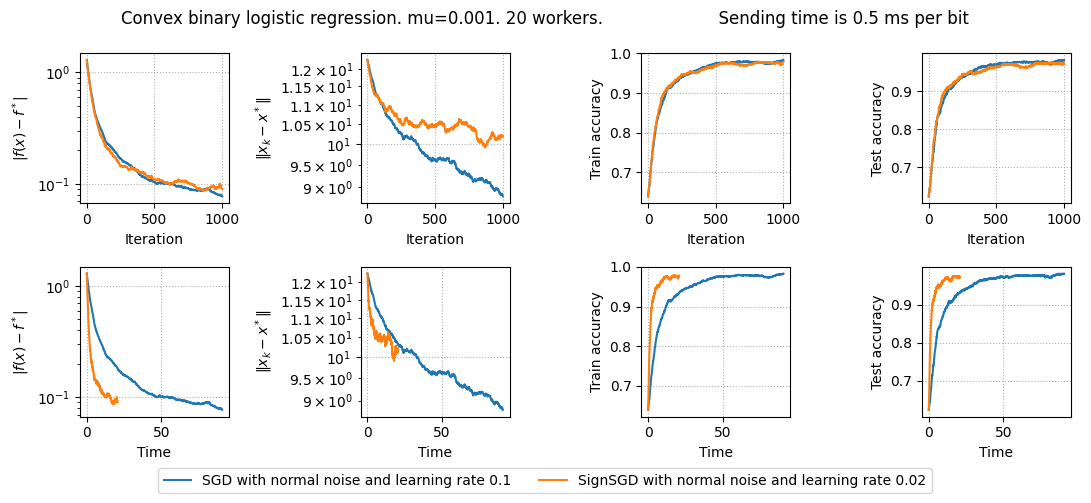

In [91]:
params = {
    "mu": 1e-3,
    "sending_time": 5e-4,
    "methods": [
        {
            "method": "SGD",
            "learning_rate": 1e-1,
            "iterations": 1000,
            "noise_type": "normal",
        },
        {
            "method": "SignSGD",
            "learning_rate": 2e-2,
            "iterations": 1000,
            "noise_type": "normal",
        },
    ]
}

results, params = run_experiments(params)

plot_results(results, params)